In [4]:
!pip3 -qq install torch==0.4.1
!pip install -q --upgrade nltk gensim bokeh pandas

!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip quora.zip

import nltk
nltk.download('punkt')

Archive:  quora.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

np.random.seed(42)

# Введение в PyTorch

PyTorch - это один из самых известных фреймворков для работы с нейронными сетями.

Почему именно он? Ну, он няшен, питоняч и проще в отладке - по сравнению с монстрами типа tensoflow (хотя tf 2.0 с eager execution будет примерно таким же).

И вообще, мы тут не фреймворки, а сеточки учить собирались :)



## Автоматическое дифференцирование

### Графы вычислений

Графы вычислений - это такой удобный способ быстро считать градиенты сложных-пресложных функций.

Например, функция

$$f = (x + y) \cdot z$$

представится графом

![graph](https://image.ibb.co/mWM0Lx/1_6o_Utr7_ENFHOK7_J4l_XJtw1g.png)  
*From [Backpropagation, Intuitions - CS231n](http://cs231n.github.io/optimization-2/)*

**Задание** Зададим значения $x, y, z$ (зеленым на картинке). Как посчитать $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}$? (*Вспоминаем, что такое backpropagation*)

В PyTorch такие вычисления делаются очень просто.

Сначала определяется функция - просто последовательность операций:

In [0]:
x = torch.tensor(-2., requires_grad=True)
y = torch.tensor(5., requires_grad=True)
z = torch.tensor(-4., requires_grad=True)

q = x + y
f = q * z

А затем говорим ей: "Посчитай градиенты, пожалуйста"

In [0]:
f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = tensor(-4.)
df/dy = tensor(-4.)


Вызов метода `backward()` вычисляет градиенты для всех тензоров, у которых `requires_grad == True`.

Есть еще альтернативный способ не вычислять градиенты - пользоваться менеджерами контекста ([Locally disabling gradient computation](https://pytorch.org/docs/stable/autograd.html#locally-disabling-gradient-computation)):
```python
torch.autograd.no_grad()
torch.autograd.enable_grad()
torch.autograd.set_grad_enabled(mode)

```

In [0]:
with torch.autograd.no_grad():
    x = torch.tensor(-2., requires_grad=True)
    y = torch.tensor(5., requires_grad=True)
    q = x + y

z = torch.tensor(-4., requires_grad=True)
f = q * z

f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = None
df/dy = None


Подробнее о том, как работает autograd, можно почитать здесь: [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html).

В целом, любой тензор в pytorch - аналог многомерных матриц в numpy.

Он содержит данные:

In [0]:
x.data

tensor(-2.)

Накопленный градиент:

In [0]:
x.grad

Функцию, как градиент считать:

In [0]:
q.grad_fn

И всякую дополнительную метаинформацию:

In [0]:
x.type(), x.shape, x.device, x.layout

('torch.FloatTensor', torch.Size([]), device(type='cpu'), torch.strided)

Зачем... У меня один вопрос - зачем вот это вот нам нужно?

### Задача для разминки

Чтобы разобраться - решим простенькую задачу на линейную регрессию:

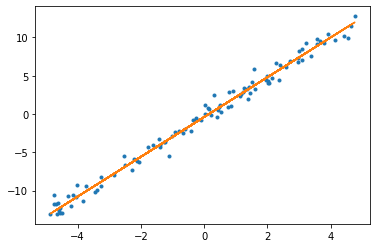

In [0]:
w_orig, b_orig = 2.6, -0.4

X = np.random.rand(100) * 10. - 5.
y_orig = w_orig * X + b_orig

y = y_orig + np.random.randn(100)

plt.plot(X, y, '.')
plt.plot(X, y_orig)
plt.show()

Хочется прикрутить сюда backpropagation, да.

Есть два параметра $w$ и $b$ - их нужно подобрать такими, чтобы они были как можно ближе к исходным $w_{orig}, b_{orig}$.

Что будем оптимизировать? Оптимизировать будем MSE:
$$J(w, b) = \frac{1}{N} \sum_{i=1}^N || \hat y_i - y_i(w, b)||^2 =\frac{1}{N} \sum_{i=1}^N || \hat y_i - (w \cdot x_i + b)||^2. $$

С такой функций потерь можем запустить простой градиентный спуск (даже не стохастический пока):
$$w_{t+1} := w_t - \alpha \cdot \frac{\partial J}{\partial w}(w_t, b_t)$$
$$b_{t+1} := w_t - \alpha \cdot \frac{\partial J}{\partial b}(w_t, b_t)$$

**Задание** Реализовать оптимизацию на чистом numpy.

Для этого нужно:
1. Посчитать значение функции на прямом проходе: $y(w, b) = w \cdot x + b$;
2. Подумать и посчитать градиенты $\frac{\partial J}{\partial w}, \frac{\partial J}{\partial b}$ на обратном проходе;
3. Сдвинуть $w, b$ по антиградиентам.

Epoch = 100, Loss = 0.7178397998887753, w = 2.5834364451199177, b = -0.031443890427106276


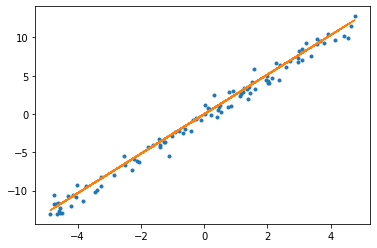

In [0]:
def display_progress(epoch, loss, w, b, X, y, y_pred):
    clear_output(True)
    print('Epoch = {}, Loss = {}, w = {}, b = {}'.format(epoch, loss, w, b))
    plt.plot(X, y, '.')
    plt.plot(X, y_pred)
    plt.show()
    time.sleep(1)


w = np.random.randn()
b = np.random.randn()



alpha = 0.01

for i in range(100):
    y_pred = w * X + b

    loss = ((y-y_pred)**2).sum()/len(y_pred)

    w_grad = -2 / (y.shape[0]) * np.sum(X * (y - y_pred))
    b_grad = -2 / (y.shape[0]) * np.sum(y - y_pred)

    w -= alpha * w_grad
    b -= alpha * b_grad
    
    if (i + 1) % 5 == 0:
        display_progress(i + 1, loss, w, b, X, y, y_pred)

На PyTorch то же самое сделать несколько проще - подсчет прямого прохода копируется почти дословно.

Обратный проход мы уже умеем - нужно просто вызвать `loss.backward()`.

Для обновления `w` и `b` нужно иметь в виду следующее. Во-первых, pytorch не даст просто так обновить их:

In [0]:
w = torch.randn(1, requires_grad=True)

w -= 1

Проблема в сложности поддержки in-place операций для работы autograd ([In place operations with autograd](https://pytorch.org/docs/stable/notes/autograd.html#in-place-operations-with-autograd)).

Но нам и не нужна поддержка градиентов! Мы не будем делать backward pass через эту операцию - нужно всего лишь обновить значение переменной. Чтобы сделать это, можно воспользовать контекстом `no_grad`, либо производить обновление непосредственно буфера, который использует данный тензор:

In [0]:
w.data -= 1.

Другое, что нужно помнить - градиенты в тензорах накапливаются. Между вызовами `loss.backward()` нужно обнулять градиенты у `w` и `b`:
```python
w.grad.zero_()
b.grad.zero_()
```

**Задание** Реализовать линейную регрессию на pytorch.

Epoch = 100, Loss = 0.6325293183326721, w = 2.5778634548187256, b = -0.3179955780506134


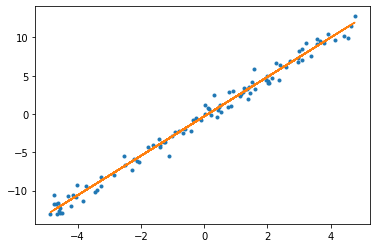

In [0]:
X = torch.as_tensor(X).float()
y = torch.as_tensor(y).float()

w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

alpha = 0.1

for i in range(100):
    y_pred = w * X + b

    loss = ((y-y_pred)**2).sum()/len(y_pred)

    loss.backward()

    w.data -= alpha * w.grad
    b.data -= alpha * b.grad
    
    w.grad.zero_()
    b.grad.zero_()
    
    if (i + 1) % 5 == 0:
        display_progress(i + 1, loss, w.item(), b.item(), 
                         X.data.numpy(), y.data.numpy(), y_pred.data.numpy())

Думать нужно уже гораздо меньше, да? :)

Про другие фишки низкоуровнего pytorch можно почитать здесь: [PyTorch — ваш новый фреймворк глубокого обучения](https://habr.com/post/334380/) (статья веселая, но немного устарела, читать лучше с оглядкой на [PyTorch 0.4.0 Migration Guide](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/))

## Word embeddings и высокоуровневый API PyTorch

Займёмся рассмотрением высокоуровневого API - в нем уже реализованы разные классы-запчасти для обучения нейронок.

Будем решать всё ту же задачу, что и в прошлый раз - обучение словных эмбеддингов, только теперь мы будем учить их самостоятельно!

Для начала нужно подготовить данные для обучения.

Соберем и токенизируем тексты:

In [0]:
import pandas as pd
from nltk.tokenize import word_tokenize

quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())

tokenized_texts = [word_tokenize(text.lower()) for text in texts]

Соберем индекс самых частотных слов:

In [7]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break
        
    word2index[word] = len(word2index)
    
index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]
    
print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 28634
Tokens count: 6969946
Unknown tokens appeared: 123601
Most freq words: ['?', 'the', 'what', 'is', 'a', 'i', 'to', 'in', 'how', 'of', 'do', 'are', 'and', 'for', ',', 'can', 'you', 'why', 'it', 'my']


### Skip-Gram Word2vec

Начнем с skip-gram модели обучения word2vec.

Это простая модель всего из двух слоев. Ее идея - учить вектора эмбеддингов такими, чтобы по ним можно было как можно лучше предсказать контекст соответствующих слов. То есть если мы хорошо научились кодировать слова, с которыми встречается данное - значит, мы что-то знаем и о нем самом. Например, естественным образом получится, что слова, встречающиеся в одинаковых контекстах (скажем, `apple` и `orange`)  будут иметь близкие вектора эмбеддингов.

![](https://ask.qcloudimg.com/http-save/yehe-1565119/pv4604cabp.jpeg)  
*From cs224n, Lecture 2*

Для этого мы моделируем вероятности $\{P(w_{c+j}|w_c):  j = c-k, ..., c+k, j \neq c\}$, где $k$ - размер контекстного окна, $c$ - индекс центрального слова.

Соберем такую модель: будем учить пару матриц $U$ - матрицу эмбеддингов, которую потом и возьмем для своих задач, и $V$ - матрицу выходного слоя.

Каждому слову в словаре соответствует строка в матрице $U$ и столбец $V$.

![skip-gram](https://image.ibb.co/khFXu9/Skip_gram.png)

Что тут происходит? Слово отображается в эмбеддинг - строку $u_c$. Дальше этот эмбеддинг умножается на матрицу $V$. 

В итоге получаем набор числе $v_j^T u_c$ - степень похожести слова с номером $j$ и нашего слова.

Преобразуем эти числа в что-то вроде вероятностей - воспользуемся функцией softmax: $P(i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$.

А дальше будем считать кросс-энтропийные потери:

$$-\sum_{-k \leq j \leq k, j \neq 0} \log \frac{\exp(v_{c+j}^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)} \to \min_{U, V}.$$

В итоге, вектор $u_c$ будет приближаться к векторам $v_{c_j}$ из его контекста.

Реализуем это всё, чтобы разобраться.

#### Генерация батчей

Для начала нужно собрать контексты.

In [0]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1) 
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))
            
    return contexts

In [0]:
contexts = build_contexts(tokenized_texts, window_size=2)

In [10]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

In [11]:
tokenized_texts[:1]

[['what',
  'is',
  'the',
  'step',
  'by',
  'step',
  'guide',
  'to',
  'invest',
  'in',
  'share',
  'market',
  'in',
  'india',
  '?']]

Преобразуем слова в индексы.

In [0]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context]) 
            for central_word, context in contexts]

In [16]:
contexts[:5]

[(3, [4, 2]),
 (4, [3, 2, 1398]),
 (2, [3, 4, 1398, 66]),
 (1398, [4, 2, 66, 1398]),
 (66, [2, 1398, 1398, 2243])]

Реализуем генератор батчей для нашей нейронки:

In [0]:
import random

def make_skip_gram_batchs_iter(contexts, window_size, num_skips, batch_size, epochs=2):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * window_size
    
    central_words = [word for word, context in contexts if len(context) == 2 * window_size and word != 0]
    contexts = [context for word, context in contexts if len(context) == 2 * window_size and word != 0]
    
    batch_size = int(batch_size / num_skips)
    batchs_count = int(math.ceil(len(contexts) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    for _ in range(epochs):
        indices = np.arange(len(contexts))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
            batch_indices = indices[batch_begin: batch_end]

            batch_data, batch_labels = [], []

            for data_ind in batch_indices:
                central_word, context = central_words[data_ind], contexts[data_ind]
                
                words_to_use = random.sample(context, num_skips)
                batch_data.extend(words_to_use)
                batch_labels.extend([central_word] * num_skips)
            
            yield batch_data, batch_labels

In [18]:
batch, labels = next(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=2, batch_size=32))

Initializing batchs generator with 295262 batchs per epoch


In [19]:
batch[3], labels[3]

(9, 12)

#### nn.Sequential

Простейший способ реализовать модель на PyTorch - использовать модуль `nn.Sequential`. В нем нужно просто перечислить все слои, и он будет применять их последовательно.

In [0]:
model = nn.Sequential(
    nn.Embedding(len(word2index), 32),
    nn.Linear(32, len(word2index))
)

Еще одна особенность pytorch, о которой до сих пор не говорили - поддержка вычислений на видеокарте. На видеокарте большинство нейронок считается гораздо быстрее благодаря высокой параллелизации. Сказать pytorch'у, чтобы он считал на видеокарте, очень просто:

In [14]:
model.cuda()

Sequential(
  (0): Embedding(28634, 32)
  (1): Linear(in_features=32, out_features=28634, bias=True)
)

либо

In [0]:
device = torch.device("cuda")

model = model.to(device)

Создать тензоры на видеокарте можно, например, так:

In [0]:
batch = torch.cuda.LongTensor(batch)
labels = torch.cuda.LongTensor(labels)

Заставить модель посчитать значение можно так:

In [0]:
logits = model(batch)

Теперь нам нужна функция потерь

In [0]:
loss_function = nn.CrossEntropyLoss().cuda() 

Посчитать значение можно так:

In [0]:
loss = loss_function(logits, labels)

А теперь, конечно же, backprop!

In [0]:
loss.backward()

И, наконец, оптимизатор.

Будем использовать Adam. Интерфейс - передать список оптимизируемых параметров и learning rate.

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.01) 

Оптимизация идет просто - нужно вызвать `step()`:

In [37]:
print(model[0].weight)

optimizer.step()

print(model[0].weight)

Parameter containing:
tensor([[ 0.9380,  0.0858,  0.4901,  ..., -0.9878,  0.0675,  0.0159],
        [ 0.0290, -0.1826, -0.0382,  ..., -0.1245,  0.0462,  0.2549],
        [ 1.2472,  0.0653, -0.1358,  ...,  0.1408,  1.1871, -0.5609],
        ...,
        [ 0.1557,  0.8079, -0.4245,  ..., -1.3827, -1.5849, -0.0385],
        [-0.1780,  1.1945,  0.6401,  ...,  0.8814, -0.1729, -0.3450],
        [ 0.7539,  1.6006,  1.3302,  ...,  0.3514, -1.3323,  0.3459]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.9380,  0.0858,  0.4901,  ..., -0.9878,  0.0675,  0.0159],
        [ 0.0190, -0.1726, -0.0282,  ..., -0.1345,  0.0362,  0.2649],
        [ 1.2372,  0.0753, -0.1258,  ...,  0.1308,  1.1771, -0.5509],
        ...,
        [ 0.1557,  0.8079, -0.4245,  ..., -1.3827, -1.5849, -0.0385],
        [-0.1780,  1.1945,  0.6401,  ...,  0.8814, -0.1729, -0.3450],
        [ 0.7539,  1.6006,  1.3302,  ...,  0.3514, -1.3323,  0.3459]],
       device='cuda:0', requires_grad=True)


И последнее - нужно обнулить градиенты!

In [0]:
optimizer.zero_grad()

#### Реализация обучения skip-gram модели

Наконец, напишем цикл обучения - как уже было с линейной регрессией.

 **Задание** Заполните цикл.

In [23]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss().cuda()

for step, (batch, labels) in enumerate(make_skip_gram_batchs_iter(contexts, window_size=2,
                                                                  num_skips=4, batch_size=256,
                                                                  epochs=20)):
    #<1. convert data to tensors>

    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)
     
    #<2. make forward pass>

    batch_res = model(batch)
    logits = F.log_softmax(batch_res)

    #<3. make backward pass>
 
    loss = loss_function(logits, labels)
    loss.backward()

    #<4. apply optimizer>
    optimizer.step()

    #<5. zero grads>
    optimizer.zero_grad()
    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 73816 batchs per epoch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Step = 1000, Avg Loss = 8.7727, Time = 4.65s
Step = 2000, Avg Loss = 7.4169, Time = 2.74s
Step = 3000, Avg Loss = 7.1168, Time = 2.76s
Step = 4000, Avg Loss = 6.9589, Time = 2.75s
Step = 5000, Avg Loss = 6.8673, Time = 2.75s
Step = 6000, Avg Loss = 6.8312, Time = 2.74s
Step = 7000, Avg Loss = 6.8047, Time = 2.75s
Step = 8000, Avg Loss = 6.7536, Time = 2.74s
Step = 9000, Avg Loss = 6.7344, Time = 2.80s
Step = 10000, Avg Loss = 6.7189, Time = 2.74s
Step = 11000, Avg Loss = 6.6907, Time = 2.75s
Step = 12000, Avg Loss = 6.6922, Time = 2.73s
Step = 13000, Avg Loss = 6.6831, Time = 2.74s
Step = 14000, Avg Loss = 6.6840, Time = 2.76s
Step = 15000, Avg Loss = 6.6710, Time = 2.76s
Step = 16000, Avg Loss = 6.6677, Time = 2.77s
Step = 17000, Avg Loss = 6.6518, Time = 2.75s
Step = 18000, Avg Loss = 6.6587, Time = 2.74s
Step = 19000, Avg Loss = 6.6546, Time = 2.74s
Step = 20000, Avg Loss = 6.6708, Time = 2.74s
Step = 21000, Avg Loss = 6.6154, Time = 2.74s
Step = 22000, Avg Loss = 6.6106, Time = 2.7

KeyboardInterrupt: ignored

#### Анализ

Получить эмбеддинги можно скаставав такое заклинание:

In [0]:
embeddings = model[0].weight.cpu().data.numpy()

Проверим, получилось ли хоть сколько-то адекватно.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]
    
    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]
    
    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings, index2word, word2index, 'people')

И визуализируем!

In [26]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]
    
    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)
    
    
visualize_embeddings(embeddings, index2word, 400)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.126468
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 78.6430283, gradient norm = 0.4367049 (50 iterations in 5.830s)
[t-SNE] Iteration 100: error = 82.1829376, gradient norm = 0.4437555 (50 iterations in 4.358s)
[t-SNE] Iteration 150: error = 82.6946106, gradient norm = 0.4235014 (50 iterations in 5.401s)
[t-SNE] Iteration 200: error = 86.8661041, gradient norm = 0.4110603 (50 iterations in 4.210s)
[t-SNE] Iteration 250: error = 86.0581818, gradient norm = 0.3911677 (50 iterations in 4.698s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.058182
[t-SNE] Iteration 300: error = 1.9904560, gradient norm = 0.0052407 (50 iterations in 3.634s)
[t-SNE] Iteration 350: error = 1.8428710, gradient norm = 0.0016334 (

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


### Continuous Bag of Words (CBoW)

Альтернативный вариант модели:

![](https://image.ibb.co/jnsW49/CBOW.png)

Теперь по *сумме* контекстных векторов предсказывается вектор центрального слова.

**Задание** Реализуйте часть функции для генерации батчей.

In [0]:
def make_cbow_batchs_iter(contexts, window_size, batch_size, epochs=2):
    data = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])
    labels = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])
        
    batchs_count = int(math.ceil(len(data) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    for _ in range(epochs):
        indices = np.arange(len(data))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
            batch_indices = indices[batch_begin: batch_end]
            batch_data, batch_labels = [], []

            for data_ind in batch_indices:
                central_word, context = labels[data_ind], data[data_ind]
                batch_labels.extend([central_word])
                batch_data.extend(context.reshape(-1, 2 * window_size))
            
            yield batch_data, batch_labels

In [37]:
batch, labels = next(make_cbow_batchs_iter(contexts, window_size=2, batch_size=32))

Initializing batchs generator with 147631 batchs per epoch


In [23]:
batch[3], labels[3]

(array([1224,   13,  108, 1865]), 278)

Посмотрим на альтернативный вариант создания модели - им мы будем пользоваться чаще всего - отнаследоваться от `nn.Module`. Схематично её использование выглядит так:

```python
class MyNetModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyNetModel, self).__init__()
        <initialize layers>
        
    def forward(self, inputs):
        <apply layers>
        return final_output
```



In [0]:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size, bias)

    def forward(self, inputs):
        emb = torch.mean(self.embeddings(inputs), dim=1)
        out = self.out_layer(emb)
        output = F.log_softmax(out)
        return output
      
model = CBoWModel(vocab_size=len(word2index), embedding_dim=32).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss().cuda()

In [41]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2,
                                                             batch_size=256, epochs=20)):
    #<1. convert data to tensors>

    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)
     
    #<2. make forward pass>

    batch_res = model(batch)
    logits = F.log_softmax(batch_res)

    #<3. make backward pass>
 
    loss = loss_function(logits, labels)
    loss.backward()

    #<4. apply optimizer>
    optimizer.step()

    #<5. zero grads>
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 18454 batchs per epoch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Step = 1000, Avg Loss = 5.2555, Time = 8.21s
Step = 2000, Avg Loss = 5.2457, Time = 3.54s
Step = 3000, Avg Loss = 5.2468, Time = 3.59s
Step = 4000, Avg Loss = 5.2354, Time = 3.54s
Step = 5000, Avg Loss = 5.2275, Time = 3.55s
Step = 6000, Avg Loss = 5.2140, Time = 3.55s
Step = 7000, Avg Loss = 5.2169, Time = 3.55s
Step = 8000, Avg Loss = 5.2066, Time = 3.55s
Step = 9000, Avg Loss = 5.2026, Time = 3.54s
Step = 10000, Avg Loss = 5.1877, Time = 3.61s
Step = 11000, Avg Loss = 5.1786, Time = 3.53s
Step = 12000, Avg Loss = 5.1699, Time = 3.53s
Step = 13000, Avg Loss = 5.1509, Time = 3.54s
Step = 14000, Avg Loss = 5.1579, Time = 3.57s
Step = 15000, Avg Loss = 5.1514, Time = 3.61s
Step = 16000, Avg Loss = 5.1471, Time = 3.60s
Step = 17000, Avg Loss = 5.1343, Time = 3.54s
Step = 18000, Avg Loss = 5.1194, Time = 3.53s
Step = 19000, Avg Loss = 5.0961, Time = 3.70s
Step = 20000, Avg Loss = 5.0631, Time = 3.61s
Step = 21000, Avg Loss = 5.0583, Time = 3.52s
Step = 22000, Avg Loss = 5.0606, Time = 3.5

KeyboardInterrupt: ignored

In [42]:
embeddings = model.embeddings.weight.cpu().data.numpy()
most_similar(embeddings, index2word, word2index, 'people')

['people',
 'guys',
 'quorans',
 'americans',
 'girls',
 'women',
 'indians',
 'men',
 'psychopaths',
 'hindus']

In [0]:
visualize_embeddings(model.embeddings.weight.data.cpu().numpy(), index2word, 1000)

### Negative Sampling

Что сейчас самое тяжелое? Вычисление softmax и применение градиентов ко всем словам в $V$.

Один из способов справиться с этим - использовать *Negative Sampling*.

По сути, вместо предсказания индекса слова по контексту предсказывается вероятность того, что такое слово может быть в таком контексте: $P(D=1|w,c)$.

Можно использовать обычную сигмоиду для получения данной вероятности: 
$$P(D=1|w, c) = \sigma(v_w^T u_c) = \frac 1 {1 + \exp(-v^T_w u_c)}.$$

Процесс обучения тогда выглядит так: для каждой пары слово и его контекст генерируем набор отрицательных примеров:

![Negative Sampling](https://image.ibb.co/dnOUDH/Negative_Sampling.png)

Для CBoW функция потерь будет выглядеть так:
$$-\log \sigma(v_c^T u_c) - \sum_{k=1}^K \log \sigma(-\tilde v_k^T u_c),$$
где $v_c$ - вектор центрального слова, $u_c$ - вектор контекста (сумма контекстных векторов), $\tilde v_1, \ldots, \tilde v_K$ - сэмплированные негативные примеры.

Сравните эту формулу с обычным CBoW:
$$-v_c^T u_c + \log \sum_{i=1}^{|V|} \exp(v_i^T u_c).$$

Обычно слова сэмплируются из $U^{3/4}$, где $U$ - униграмное распределение, т.е частоты появления слова делённые на суммарое число слов. 

Частотности мы уже считали: они получаются в `Counter(words)`. Достаточно просто преобразовать их в вероятности и домножить эти вероятности на $\frac 3 4$. Почему $\frac 3 4$? Некоторую интуицию можно найти в следующем примере:

$$P(\text{is}) = 0.9, \ P(\text{is})^{3/4} = 0.92$$
$$P(\text{Constitution}) = 0.09, \ P(\text{Constitution})^{3/4} = 0.16$$
$$P(\text{bombastic}) = 0.01, \ P(\text{bombastic})^{3/4} = 0.032$$

Вероятность для высокочастотных слов особо не увеличилась (относительно), зато низкочастотные будут выпадать с заметно большей вероятностей.

**Задание** Реализуйте свой Negative Sampling.

Для начала зададим распределение для сэмплирования:

In [44]:
words_sum_count = sum(words_counter.values())
word_distribution = np.array([(words_counter[word] / words_sum_count) ** (3 / 4) for word in index2word])
word_distribution /= word_distribution.sum()

indices = np.arange(len(word_distribution))

np.random.choice(indices, p=word_distribution, size=(32, 5))

array([[   36,  4061, 17274,  1984,  6062],
       [    2,  1078,   805, 16036,   200],
       [   66,     1,   187,  6641,  1353],
       [ 6198,   155,    70,     1,   225],
       [21163,   387,  2946, 10422,    28],
       [   59,   451,   917, 21978,     1],
       [ 1557,     2, 10108,    57,  3302],
       [  588, 11829,     7,   537,   683],
       [ 1830,   111,     1,  4008,    31],
       [ 1630,  1203,    16,  1921,   913],
       [11212,  2098,  2075,   855,  4035],
       [ 6696,  1175,    44,  5308,  2873],
       [15381,  2182,    29,     6,     7],
       [    2,    96,  3797, 17482,  6718],
       [ 1655,   684,   367,  1896,   445],
       [ 2221,   207,  4143,   417,     1],
       [  192,    62,    41,  2568,     8],
       [   75,    16,     7,    87,  1064],
       [ 1006,  4214,  5655,  2422,  2322],
       [ 2015,    12,    19,   692,  1533],
       [ 4409,    23,  2733,     5,   929],
       [  338,    70,  9198,    10,   958],
       [    4,    26,  5675,   1

In [0]:
 class NegativeSamplingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.loss_function = nn.CrossEntropyLoss().cuda()

    def forward(self, inputs, targets, num_samples):
        '''
        inputs: (batch_size, context_size)
        targets: (batch_size)
        num_samples: int
        '''
        
        batch_size, context_size = inputs.shape

        u_c = torch.sum(self.embeddings(inputs), dim=1)
        v_c = self.embeddings(targets)
        
        indices = np.arange(len(word_distribution))
        sample = torch.cuda.LongTensor(np.random.choice(indices,
                                                        p=word_distribution,
                                                        size=(batch_size, num_samples)))
        
        neg_embeddings = (-1) * self.embeddings(sample)

        positive_scores = F.logsigmoid(torch.sum(u_c * v_c, dim = 1))
        negative_scores = torch.sum(F.logsigmoid(torch.sum(u_c.reshape(batch_size, 1, -1) * neg_embeddings, dim=2)), dim=1)

        loss = - negative_scores - positive_scores
        return torch.mean(loss)

In [53]:
model = NegativeSamplingModel(vocab_size=len(word2index), embedding_dim=32).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.01)  

loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts,
                                                             window_size=2,
                                                             batch_size=256,
                                                             epochs=20)):
#     <1. convert data to tensors>
    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)
#     <2. make forward pass>
    loss = model.forward(inputs=batch, targets=labels, num_samples=6)
#     <3. make backward pass>
    loss.backward()
#     <4. apply optimizer>
    optimizer.step()
#     <5. zero grads>|
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 18454 batchs per epoch
Step = 1000, Avg Loss = 12.5510, Time = 7.24s
Step = 2000, Avg Loss = 6.5929, Time = 2.60s
Step = 3000, Avg Loss = 5.7223, Time = 2.81s
Step = 4000, Avg Loss = 5.3758, Time = 2.60s
Step = 5000, Avg Loss = 5.2020, Time = 2.62s
Step = 6000, Avg Loss = 5.1222, Time = 2.69s
Step = 7000, Avg Loss = 5.0808, Time = 2.61s
Step = 8000, Avg Loss = 5.0608, Time = 2.66s
Step = 9000, Avg Loss = 5.0364, Time = 2.83s
Step = 10000, Avg Loss = 5.0290, Time = 2.66s
Step = 11000, Avg Loss = 5.0161, Time = 2.73s
Step = 12000, Avg Loss = 5.0041, Time = 2.69s
Step = 13000, Avg Loss = 5.0055, Time = 2.61s
Step = 14000, Avg Loss = 4.9936, Time = 2.64s
Step = 15000, Avg Loss = 4.9864, Time = 2.59s
Step = 16000, Avg Loss = 4.9814, Time = 2.62s
Step = 17000, Avg Loss = 4.9828, Time = 2.64s
Step = 18000, Avg Loss = 4.9771, Time = 2.72s
Step = 19000, Avg Loss = 4.9748, Time = 2.87s
Step = 20000, Avg Loss = 4.9656, Time = 3.03s
Step = 21000, Avg Loss = 4.971

KeyboardInterrupt: ignored

In [0]:
visualize_embeddings(model.embeddings.weight.data.cpu().numpy(), index2word, 1000)

# Дополнительные материалы
## Почитать
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[On word embeddings - Part 2: Approximating the Softmax, Sebastian Ruder](http://ruder.io/word-embeddings-softmax/index.html)  
[Word2Vec Tutorial - The Skip-Gram Model, ](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

## Посмотреть
[cs224n "Lecture 2 - Word Vector Representations: word2vec"](https://www.youtube.com/watch?v=ERibwqs9p38&index=2&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)  
[cs224n "Lecture 5 - Backpropagation"](https://www.youtube.com/watch?v=isPiE-DBagM&index=5&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)   


# Сдача задания

[Сдача](https://goo.gl/forms/rzWjQQsGpqYNz5yt1)  
[Опрос](https://goo.gl/forms/as640TWE058bFTpy2)